# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [28]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [29]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 12, 13, 41, 755659)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [30]:
os.environ["HOPSWORKS_API_KEY"] = "hN2itDTj1upyev1f.yLm5qtPpASQXEv7GJA79T2c6wSUnsNCNFxgRMbmnSbJHA1i31wgrSgmnAEVmb4wo"
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1169556
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [31]:
feature_view = fs.get_feature_view(
    name='air_quality_fv2',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [32]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=5,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [33]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.4168524E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [34]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data = batch_data.sort_values(by='date')
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
2,2024-11-20 00:00:00+00:00,1.60,0.0,18.947083,14.300317,stockholm
0,2024-11-21 00:00:00+00:00,-2.65,0.7,28.666941,305.286835,stockholm
1,2024-11-22 00:00:00+00:00,-4.90,0.0,16.622490,287.650208,stockholm
3,2024-11-23 00:00:00+00:00,-4.10,0.0,10.805999,271.909119,stockholm
5,2024-11-24 00:00:00+00:00,3.75,0.0,18.899143,139.635544,stockholm
6,2024-11-25 00:00:00+00:00,6.85,0.0,23.400002,194.250061,stockholm
7,2024-11-26 00:00:00+00:00,3.50,0.1,15.463244,282.094727,stockholm
4,2024-11-27 00:00:00+00:00,0.20,0.0,14.003029,287.969238,stockholm


In [35]:
air_quality_fg_2 = fs.get_feature_group(
    name='air_quality2',
    version=1,
)
date_and_city = batch_data[['date', 'city']]

air_quality_fg_2
d = air_quality_fg_2.read()
d = d.sort_values(by='date', ascending=False)
today_row = d.iloc[0]
today_pm25 = today_row['pm25']
today_lag_1 = today_row['pm25_lag_1']
today_lag_2 = today_row['pm25_lag_2']

feature_order = [
    'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3',
    'temperature_2m_mean', 'precipitation_sum', 
    'wind_speed_10m_max', 'wind_direction_10m_dominant'
]

# Sort batch_data by date in ascending order to process in time sequence
batch_data = batch_data.sort_values(by='date', ascending=True).reset_index(drop=True)

batch_data['pm25_lag_1'] = None
batch_data['pm25_lag_2'] = None
batch_data['pm25_lag_3'] = None

batch_data.loc[0, 'pm25_lag_1'] = today_pm25
batch_data.loc[0, 'pm25_lag_2'] = today_lag_1
batch_data.loc[0, 'pm25_lag_3'] = today_lag_2
batch_data = batch_data[feature_order].astype('float32')


print("Batch data:", batch_data)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 
Batch data:    pm25_lag_1  pm25_lag_2  pm25_lag_3  temperature_2m_mean  precipitation_sum  \
0        28.0        17.0        14.0                 1.60                0.0   
1         NaN         NaN         NaN                -2.65                0.7   
2         NaN         NaN         NaN                -4.90                0.0   
3         NaN         NaN         NaN                -4.10                0.0   
4         NaN         NaN         NaN                 3.75                0.0   
5         NaN         NaN         NaN                 6.85                0.0   
6         NaN         NaN         NaN                 3.50                0.1   
7         NaN         NaN         NaN                 0.20                0.0   

   wind_speed_10m_max  wind_direction_10m_dominant  
0           18.947083                    14.300317  
1           28.666941                   305.286835  
2           1

In [36]:
for i in range(len(batch_data)):
    input_data = batch_data.loc[i, feature_order].to_frame().T
    predicted_pm25 = retrieved_xgboost_model.predict(input_data)[0]
    batch_data.loc[i, 'predicted_pm25'] = predicted_pm25

    if i + 1 < len(batch_data):
        batch_data.loc[i + 1, 'pm25_lag_1'] = predicted_pm25
        batch_data.loc[i + 1, 'pm25_lag_2'] = batch_data.loc[i, 'pm25_lag_1']
        batch_data.loc[i + 1, 'pm25_lag_3'] = batch_data.loc[i, 'pm25_lag_2']

batch_data.insert(4, 'date', date_and_city['date'].reset_index(drop=True))
batch_data.insert(len(batch_data.columns) - 1, 'city', date_and_city['city'].reset_index(drop=True))

batch_data

,pm25_lag_1,pm25_lag_2,pm25_lag_3,temperature_2m_mean,date,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,28.000000,17.000000,14.000000,1.60,2024-11-20 00:00:00+00:00,0.0,18.947083,14.300317,stockholm,15.768944
1,15.768944,28.000000,17.000000,-2.65,2024-11-21 00:00:00+00:00,0.7,28.666941,305.286835,stockholm,16.250799
2,16.250799,15.768944,28.000000,-4.90,2024-11-22 00:00:00+00:00,0.0,16.622490,287.650208,stockholm,15.074847
3,15.074847,16.250799,15.768944,-4.10,2024-11-23 00:00:00+00:00,0.0,10.805999,271.909119,stockholm,23.915968
4,23.915968,15.074847,16.250799,3.75,2024-11-24 00:00:00+00:00,0.0,18.899143,139.635544,stockholm,29.234495
5,29.234495,23.915968,15.074847,6.85,2024-11-25 00:00:00+00:00,0.0,23.400002,194.250061,stockholm,42.290745
6,42.290745,29.234495,23.915968,3.50,2024-11-26 00:00:00+00:00,0.1,15.463244,282.094727,stockholm,31.134912
7,31.134912,42.290745,29.234495,0.20,2024-11-27 00:00:00+00:00,0.0,14.003029,287.969238,stockholm,31.150442


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [37]:
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
#batch_data

In [38]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   pm25_lag_1                   8 non-null      float32            
 1   pm25_lag_2                   8 non-null      float32            
 2   pm25_lag_3                   8 non-null      float32            
 3   temperature_2m_mean          8 non-null      float32            
 4   date                         8 non-null      datetime64[us, UTC]
 5   precipitation_sum            8 non-null      float32            
 6   wind_speed_10m_max           8 non-null      float32            
 7   wind_direction_10m_dominant  8 non-null      float32            
 8   city                         8 non-null      object             
 9   predicted_pm25               8 non-null      float64            
dtypes: datetime64[us, UTC](1), float32(7), float64(1), obj

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [39]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,pm25_lag_1,pm25_lag_2,pm25_lag_3,temperature_2m_mean,date,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,28.000000,17.000000,14.000000,1.60,2024-11-20 00:00:00+00:00,0.0,18.947083,14.300317,stockholm,15.768944,stockholm-st-eriksgatan-83,sweden,1
1,15.768944,28.000000,17.000000,-2.65,2024-11-21 00:00:00+00:00,0.7,28.666941,305.286835,stockholm,16.250799,stockholm-st-eriksgatan-83,sweden,2
2,16.250799,15.768944,28.000000,-4.90,2024-11-22 00:00:00+00:00,0.0,16.622490,287.650208,stockholm,15.074847,stockholm-st-eriksgatan-83,sweden,3
3,15.074847,16.250799,15.768944,-4.10,2024-11-23 00:00:00+00:00,0.0,10.805999,271.909119,stockholm,23.915968,stockholm-st-eriksgatan-83,sweden,4
4,23.915968,15.074847,16.250799,3.75,2024-11-24 00:00:00+00:00,0.0,18.899143,139.635544,stockholm,29.234495,stockholm-st-eriksgatan-83,sweden,5
5,29.234495,23.915968,15.074847,6.85,2024-11-25 00:00:00+00:00,0.0,23.400002,194.250061,stockholm,42.290745,stockholm-st-eriksgatan-83,sweden,6
6,42.290745,29.234495,23.915968,3.50,2024-11-26 00:00:00+00:00,0.1,15.463244,282.094727,stockholm,31.134912,stockholm-st-eriksgatan-83,sweden,7
7,31.134912,42.290745,29.234495,0.20,2024-11-27 00:00:00+00:00,0.0,14.003029,287.969238,stockholm,31.150442,stockholm-st-eriksgatan-83,sweden,8


In [40]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   pm25_lag_1                   8 non-null      float32            
 1   pm25_lag_2                   8 non-null      float32            
 2   pm25_lag_3                   8 non-null      float32            
 3   temperature_2m_mean          8 non-null      float32            
 4   date                         8 non-null      datetime64[us, UTC]
 5   precipitation_sum            8 non-null      float32            
 6   wind_speed_10m_max           8 non-null      float32            
 7   wind_direction_10m_dominant  8 non-null      float32            
 8   city                         8 non-null      object             
 9   predicted_pm25               8 non-null      float64            
 10  street                       8 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-19 12:14:47,615 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



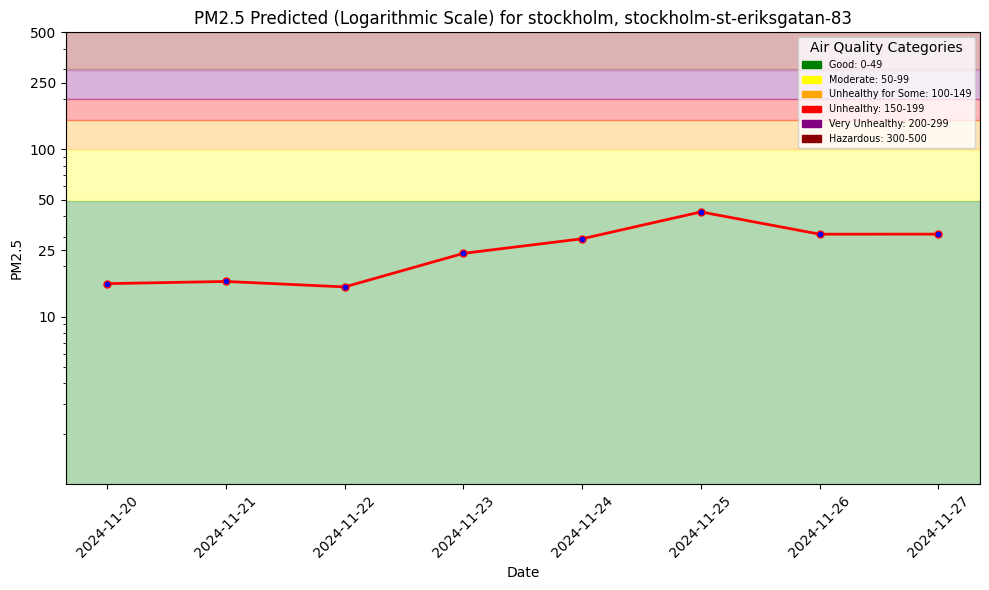

In [41]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [42]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions2',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [43]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/8 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions2_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1169556/jobs/named/aq_predictions2_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x1368a5650>, None)

In [47]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
print(batch_data)
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

   pm25_lag_1  pm25_lag_2  pm25_lag_3  temperature_2m_mean  \
0   28.000000   17.000000   14.000000                 1.60   
1   15.768944   28.000000   17.000000                -2.65   
2   16.250799   15.768944   28.000000                -4.90   
3   15.074847   16.250799   15.768944                -4.10   
4   23.915968   15.074847   16.250799                 3.75   
5   29.234495   23.915968   15.074847                 6.85   
6   42.290745   29.234495   23.915968                 3.50   
7   31.134912   42.290745   29.234495                 0.20   

                       date  precipitation_sum  wind_speed_10m_max  \
0 2024-11-20 00:00:00+00:00                0.0           18.947083   
1 2024-11-21 00:00:00+00:00                0.7           28.666941   
2 2024-11-22 00:00:00+00:00                0.0           16.622490   
3 2024-11-23 00:00:00+00:00                0.0           10.805999   
4 2024-11-24 00:00:00+00:00                0.0           18.899143   
5 2024-11-25 00:00:00

,pm25_lag_1,pm25_lag_2,pm25_lag_3,temperature_2m_mean,date,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,17.0,14.0,13.0,1.95,2024-11-19 00:00:00+00:00,0.0,6.034700,107.354111,stockholm,18.120291,stockholm-st-eriksgatan-83,sweden,1
1,28.0,17.0,14.0,1.60,2024-11-20 00:00:00+00:00,0.0,18.947083,14.300317,stockholm,15.768944,stockholm-st-eriksgatan-83,sweden,1


In [48]:
air_quality_fg = fs.get_feature_group(
    name='air_quality2',
    version=1,
)
air_quality_df = air_quality_fg.read().sort_values(by='date')
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 


,date,pm25,pm25_lag_1,pm25_lag_2,pm25_lag_3,country,city,street,url
1892,2018-04-09 00:00:00+00:00,55.0,12.0,10.0,11.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
1164,2018-04-10 00:00:00+00:00,14.0,55.0,12.0,10.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
674,2018-04-11 00:00:00+00:00,23.0,14.0,55.0,12.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
369,2018-04-12 00:00:00+00:00,26.0,23.0,14.0,55.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
1584,2018-04-13 00:00:00+00:00,33.0,26.0,23.0,14.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
...,...,...,...,...,...,...,...,...,...
2186,2024-11-15 00:00:00+00:00,22.0,25.0,21.0,21.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
2187,2024-11-16 00:00:00+00:00,13.0,22.0,25.0,21.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
2184,2024-11-17 00:00:00+00:00,14.0,13.0,22.0,25.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523
2188,2024-11-18 00:00:00+00:00,17.0,14.0,13.0,22.0,sweden,stockholm,stockholm-st-eriksgatan-83,https://api.waqi.info/feed/@10523


In [49]:
outcome_df = air_quality_df[['date', 'pm25']]
print(outcome_df.dtypes)
print("Null values before cleaning:", outcome_df.isnull().sum())
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
print(hindcast_df.dtypes)
hindcast_df = hindcast_df.sort_values(by=['date'])
print("Null values before cleaning:", hindcast_df.isnull().sum())

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

date    datetime64[us, UTC]
pm25                float32
dtype: object
Null values before cleaning: date    0
pm25    0
dtype: int64
date              datetime64[us, UTC]
predicted_pm25                float64
pm25                          float32
dtype: object
Null values before cleaning: date              0
predicted_pm25    0
pm25              0
dtype: int64


,date,predicted_pm25,pm25
0,2024-11-19 00:00:00+00:00,18.120291,28.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

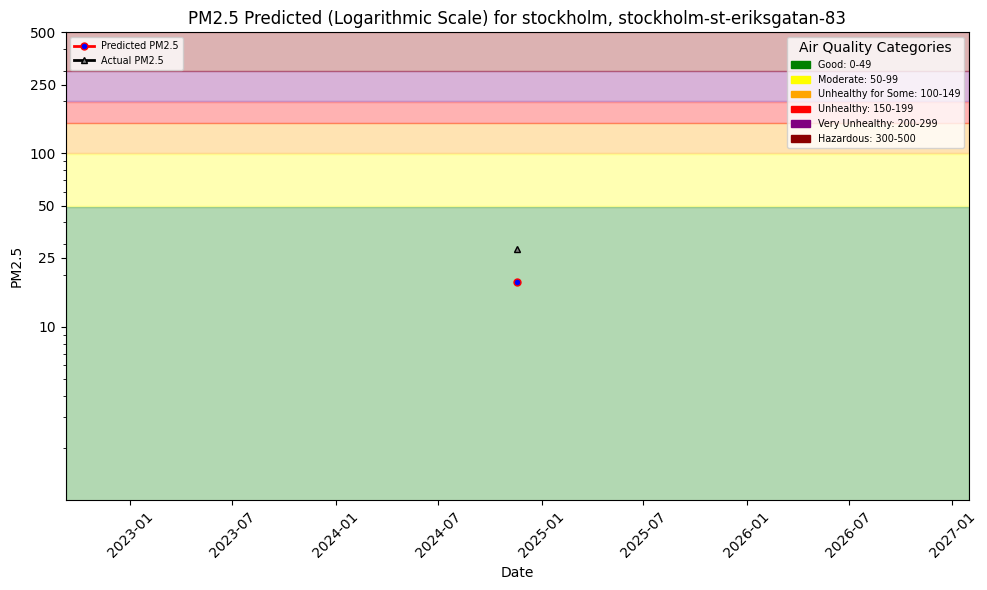

In [50]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---